In [8]:
# %pip install pycaret[full]
# %pip install ctgan

In [1]:
from pycaret.classification import *
from ctgan import CTGAN
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd

In [2]:
df = pd.read_csv("./creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
# Check if dataset has any NaN
df.isnull().any().any()

False

In [4]:
# Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [5]:
2 * 24 * 60 * 60 # 2 days of data in seconds

172800

In [6]:
# Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# Test size of 8 hours, remaining for training
test_hours = 8
train_hours = 48 - test_hours
train_delta = train_hours * 60 * 60 # Convert to seconds
train_df = df[(df['Time'] >= 0) & (df['Time'] < train_delta)]
test_df = df[df['Time'] >= train_delta]

In [8]:
train_df['Class'].value_counts()

0    224450
1       415
Name: Class, dtype: int64

In [9]:
test_df['Class'].value_counts()

0    59865
1       77
Name: Class, dtype: int64

# Baseline Models

In [68]:
cc = setup(data=train_df, target='Class', session_id=42, train_size=0.80)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(224865, 31)"
4,Transformed data shape,"(224865, 31)"
5,Transformed train set shape,"(179892, 31)"
6,Transformed test set shape,"(44973, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [69]:
best_baseline_model = cc.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9996,0.9770,0.8254,0.9371,0.8757,0.8754,0.8782,6.7260
qda,Quadratic Discriminant Analysis,0.9763,0.9677,0.8705,0.0639,0.1191,0.1160,0.2322,0.1640
ada,Ada Boost Classifier,0.9992,0.9676,0.7411,0.8113,0.7718,0.7714,0.7736,4.1370
nb,Naive Bayes,0.9915,0.9666,0.6867,0.1383,0.2301,0.2277,0.3056,0.1940
rf,Random Forest Classifier,0.9995,0.9518,0.7953,0.9395,0.8605,0.8603,0.8637,7.2300
et,Extra Trees Classifier,0.9995,0.9515,0.7953,0.9469,0.8631,0.8629,0.8669,1.5410
lr,Logistic Regression,0.9991,0.9409,0.6113,0.8510,0.7072,0.7067,0.7186,1.2580
lda,Linear Discriminant Analysis,0.9993,0.9095,0.7560,0.8530,0.7993,0.7990,0.8016,0.2000
dt,Decision Tree Classifier,0.9991,0.8900,0.7804,0.7515,0.7636,0.7631,0.7643,0.9070
gbc,Gradient Boosting Classifier,0.9991,0.7755,0.6454,0.8394,0.7189,0.7185,0.7298,21.7400


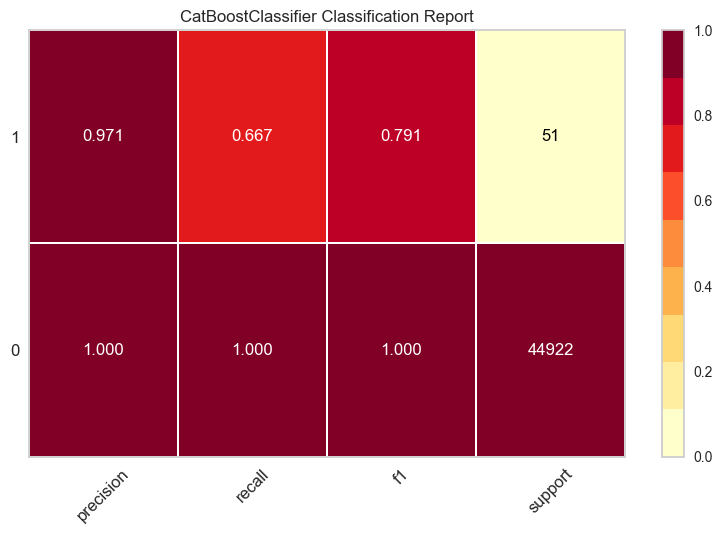

In [12]:
cc.plot_model(best_baseline_model, plot='class_report')

In [70]:
pred_df = cc.predict_model(best_baseline_model, data=test_df.copy().drop('Class', axis=1))

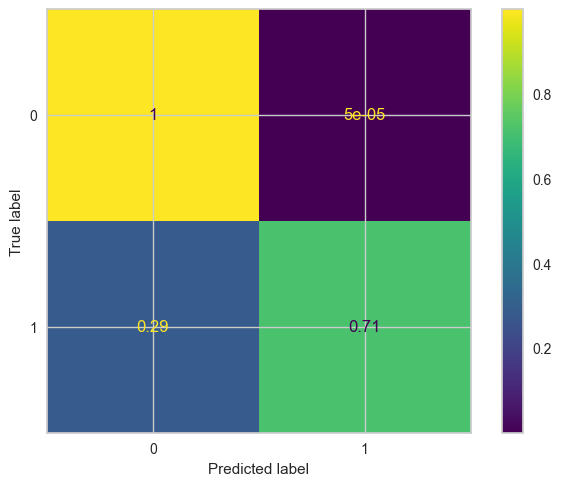

In [73]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_df['prediction_label'], normalize="true")

In [74]:
print(classification_report(test_df['Class'], pred_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       0.95      0.71      0.81        77

    accuracy                           1.00     59942
   macro avg       0.97      0.86      0.91     59942
weighted avg       1.00      1.00      1.00     59942



# CTGAN

In [18]:
discrete_columns = ['Class']
ctgan = CTGAN(epochs=300, verbose=True)
ctgan.fit(train_df, discrete_columns)

Gen. (-0.40) | Discrim. (-0.32): 100%|██████████| 300/300 [1:07:08<00:00, 13.43s/it]


In [207]:
synthetic_train = ctgan.sample(train_df[train_df['Class'] == 0]['Class'].value_counts()[0])

In [208]:
synthetic_train['Class'].value_counts()

1    125573
0     98877
Name: Class, dtype: int64

In [210]:
gan_train_df = pd.concat([train_df, synthetic_train[synthetic_train['Class'] == 1]], ignore_index=True)
gan_train_df['Class'].value_counts()

0    224450
1    125988
Name: Class, dtype: int64

In [211]:
cc_gan = setup(data=gan_train_df, target='Class', session_id=42, train_size=0.80)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(350438, 31)"
4,Transformed data shape,"(350438, 31)"
5,Transformed train set shape,"(280350, 31)"
6,Transformed test set shape,"(70088, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [80]:
best_synthetic_model = cc_gan.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9961,0.9998,0.9907,0.9985,0.9946,0.9916,0.9916,10.7170
et,Extra Trees Classifier,0.9854,0.9994,0.9624,0.9967,0.9793,0.9680,0.9683,6.9750
rf,Random Forest Classifier,0.9875,0.9991,0.9707,0.9945,0.9824,0.9728,0.9730,22.5370
lightgbm,Light Gradient Boosting Machine,0.9856,0.9987,0.9664,0.9935,0.9797,0.9686,0.9688,0.7620
gbc,Gradient Boosting Classifier,0.9622,0.9920,0.9127,0.9807,0.9455,0.9166,0.9180,38.6630
ada,Ada Boost Classifier,0.9539,0.9864,0.9053,0.9641,0.9338,0.8985,0.8995,6.7770
qda,Quadratic Discriminant Analysis,0.9220,0.9704,0.8594,0.9182,0.8878,0.8282,0.8292,0.2410
lda,Linear Discriminant Analysis,0.9021,0.9691,0.7415,0.9812,0.8447,0.7752,0.7914,0.3380
lr,Logistic Regression,0.9381,0.9682,0.8774,0.9463,0.9105,0.8633,0.8648,0.7730
dt,Decision Tree Classifier,0.9675,0.9639,0.9510,0.9582,0.9546,0.9293,0.9293,2.8310


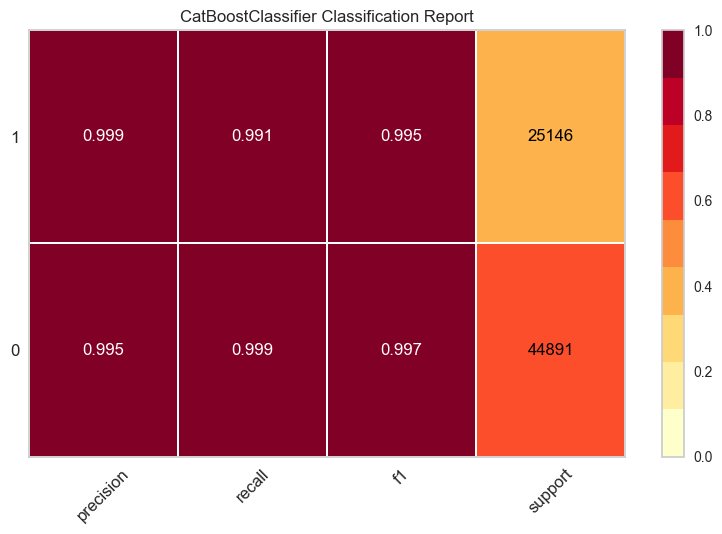

In [81]:
cc_gan.plot_model(best_synthetic_model, plot='class_report')

In [82]:
pred_gan_df = cc_gan.predict_model(best_synthetic_model, data=test_df.copy().drop('Class', axis=1))

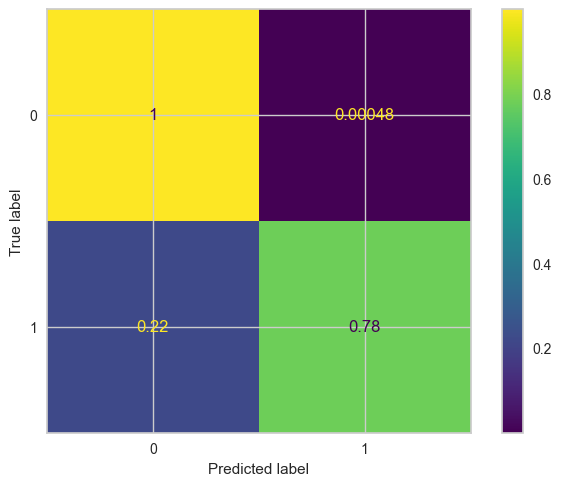

In [85]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_gan_df['prediction_label'], normalize="true")

In [86]:
print(classification_report(test_df['Class'], pred_gan_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       0.67      0.78      0.72        77

    accuracy                           1.00     59942
   macro avg       0.84      0.89      0.86     59942
weighted avg       1.00      1.00      1.00     59942



# WGAN

In [87]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import numpy as np

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [233]:
class FraudDataset(Dataset):
    def __init__(self, in_df):
        self.df = in_df[in_df['Class'] == 1].copy()
        self.x_train = torch.Tensor(self.df.drop(['Class'], axis=1).values).to(DEVICE)
        self.features = self.x_train.shape[1]

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx]

In [251]:
class Generator(nn.Module):
    def __init__(self, latent_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, output_size),
        )

    def forward(self, x):
        return self.model(x)

In [252]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.model(x)

In [253]:
class WGAN:
    def __init__(self, train_df, latent_size=128):
        # WGAN values from paper
        self.lr = 0.00005
        self.batch_size = 64
        self.n_critic = 5
        self.clip_value = 0.01

        self.dataset = FraudDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_size=latent_size, output_size=self.dataset.features).to(DEVICE)
        self.D = Discriminator(input_size=self.dataset.features).to(DEVICE)
        self.latent_size = latent_size

        self.g_optimizer = optim.RMSprop(self.G.parameters(), lr=self.lr)
        self.d_optimizer = optim.RMSprop(self.D.parameters(), lr=self.lr)

    def train(self, epochs=1000):
        for epoch in range(epochs):
            for i, real_frauds in enumerate(self.dataloader):
                # Train Discriminator
                self.d_optimizer.zero_grad()
                z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (real_frauds.shape[0], self.latent_size))).to(DEVICE))
                fake_frauds = self.G(z).detach()
                # Adversarial Loss
                loss_D = -torch.mean(self.D(real_frauds)) + torch.mean(self.D(fake_frauds))
                loss_D.backward()
                self.d_optimizer.step()

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)

                # Train the generator every n_critic iterations
                if i % self.n_critic == 0:
                    # Train Generator
                    self.g_optimizer.zero_grad()
                    gen_frauds = self.G(z)
                    # Adversarial Loss
                    loss_G = -torch.mean(self.D(gen_frauds))
                    loss_G.backward()
                    self.g_optimizer.step()
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, epochs, loss_D.item(), loss_G.item()))

    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(DEVICE)
            gen = self.G(z)
            return gen.cpu().numpy()

In [254]:
wgan = WGAN(train_df)

In [255]:
wgan.train(epochs=1000)

[Epoch 0/1000] [D loss: -0.000599] [G loss: -0.010207]
[Epoch 1/1000] [D loss: -0.000796] [G loss: -0.010300]
[Epoch 2/1000] [D loss: -0.000870] [G loss: -0.010462]
[Epoch 3/1000] [D loss: -0.000733] [G loss: -0.010561]
[Epoch 4/1000] [D loss: -0.000840] [G loss: -0.010639]
[Epoch 5/1000] [D loss: -0.000798] [G loss: -0.010787]
[Epoch 6/1000] [D loss: -0.000759] [G loss: -0.010794]
[Epoch 7/1000] [D loss: -0.000983] [G loss: -0.010889]
[Epoch 8/1000] [D loss: -0.000910] [G loss: -0.010810]
[Epoch 9/1000] [D loss: -0.001049] [G loss: -0.010747]
[Epoch 10/1000] [D loss: -0.001056] [G loss: -0.010558]
[Epoch 11/1000] [D loss: -0.001277] [G loss: -0.010403]
[Epoch 12/1000] [D loss: -0.001567] [G loss: -0.010274]
[Epoch 13/1000] [D loss: -0.001768] [G loss: -0.010151]
[Epoch 14/1000] [D loss: -0.001910] [G loss: -0.009929]
[Epoch 15/1000] [D loss: -0.002190] [G loss: -0.009864]
[Epoch 16/1000] [D loss: -0.002558] [G loss: -0.009686]
[Epoch 17/1000] [D loss: -0.002913] [G loss: -0.009535]
[E

In [256]:
wgan_nsamples = train_df[train_df['Class'] == 0]['Class'].value_counts()[0]
wgan_samples = wgan.sample(wgan_nsamples)
wgan_samples = np.append(wgan_samples, np.ones((wgan_nsamples, 1)), axis=1)
wgan_df = pd.DataFrame(wgan_samples, columns=train_df.columns)

In [257]:
wgan_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.415891,-4.411797,-2.183316,-0.728106,-3.178309,6.457277,3.034195,2.148984,-2.519067,3.311571,...,2.465146,1.440446,1.172890,-3.946738,4.508378,-0.540363,1.800993,-5.528742,3.302358,1.0
1,-1.200523,-1.042172,0.085523,0.430697,-0.006102,0.379195,0.516715,0.258146,0.125121,0.513425,...,0.149679,-0.296340,0.079892,0.043600,0.282388,0.400356,-0.101434,-1.150728,-0.183858,1.0
2,7.680621,-2.418926,-0.607628,-0.093194,-0.944492,2.854140,0.292681,-0.642910,-0.947516,0.901243,...,0.964066,0.620389,-0.227218,-2.003879,1.900801,-0.743623,0.852001,-1.935614,1.403951,1.0
3,0.813684,0.991751,0.445457,0.374232,0.548926,-1.248034,-0.309562,-0.141213,0.251847,-0.748366,...,-0.584872,-0.047351,-0.170687,1.264057,-0.930209,0.091133,-0.315887,1.450750,-0.474536,1.0
4,0.934043,0.451646,0.039167,0.264805,-0.060298,0.056558,-0.221446,0.104645,0.140282,-0.492103,...,0.136444,-0.152216,-0.258168,0.909056,-0.368842,0.077886,-0.095157,0.833170,0.154755,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224445,-13.162045,-1.574382,-0.793462,-0.426212,0.423812,1.894520,1.592183,1.646774,-0.562437,0.126698,...,0.026135,-0.711405,0.821496,-1.192955,0.199079,0.484048,-0.040146,-2.271313,-0.241801,1.0
224446,0.726137,0.680095,0.784302,0.210883,0.144975,-0.871387,-0.357128,-0.031506,0.418082,-0.454848,...,-0.151844,-0.245355,0.133251,0.567268,-0.776804,-0.151680,-0.039945,0.475499,-0.467981,1.0
224447,0.994401,0.246821,0.510964,0.365846,0.395488,-0.450584,-0.936308,-0.085942,0.105486,-1.086541,...,-0.032830,-0.273882,0.086237,0.017794,-0.778521,-0.050656,0.324587,0.328175,-0.212101,1.0
224448,0.051177,0.364399,0.834030,0.305687,0.140027,-0.912582,-0.165886,0.021714,0.158480,-1.197327,...,-0.545098,-0.033596,0.281306,-0.471272,-0.358795,-0.138308,-0.464261,0.968359,-0.521898,1.0


In [258]:
wgan_train_df = pd.concat([train_df, wgan_df], ignore_index=True)
wgan_train_df['Class'].value_counts()

1.0    224865
0.0    224450
Name: Class, dtype: int64

In [98]:
cc_wgan = setup(data=wgan_train_df, target='Class', session_id=42, train_size=0.80)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(448900, 31)"
4,Transformed data shape,"(448900, 31)"
5,Transformed train set shape,"(359120, 31)"
6,Transformed test set shape,"(89780, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [99]:
best_wgan_model = cc_wgan.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9997,1.0000,0.9996,0.9999,0.9997,0.9995,0.9995,10.3870
rf,Random Forest Classifier,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,12.2690
ada,Ada Boost Classifier,0.9995,0.9999,0.9994,0.9996,0.9995,0.9990,0.9990,9.9960
gbc,Gradient Boosting Classifier,0.9997,0.9999,0.9995,0.9998,0.9997,0.9993,0.9993,50.3840
et,Extra Trees Classifier,0.9997,0.9999,0.9996,0.9999,0.9997,0.9995,0.9995,5.8560
lightgbm,Light Gradient Boosting Machine,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,0.6440
dt,Decision Tree Classifier,0.9995,0.9995,0.9995,0.9994,0.9995,0.9989,0.9989,1.5090
qda,Quadratic Discriminant Analysis,0.9994,0.9994,0.9989,0.9999,0.9994,0.9988,0.9988,0.3440
lr,Logistic Regression,0.9973,0.9993,0.9991,0.9955,0.9973,0.9946,0.9946,2.5310
knn,K Neighbors Classifier,0.9987,0.9991,0.9982,0.9992,0.9987,0.9975,0.9975,8.4290


In [100]:
pred_wgan_df = cc_wgan.predict_model(best_wgan_model, data=test_df.copy().drop('Class', axis=1))

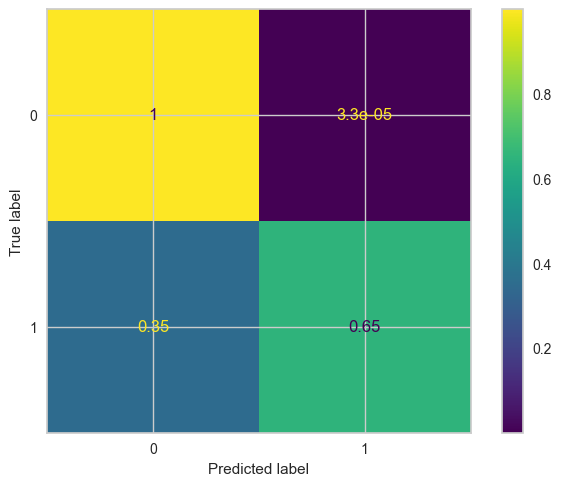

In [101]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_wgan_df['prediction_label'], normalize="true")

In [102]:
print(classification_report(test_df['Class'], pred_wgan_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       0.96      0.65      0.78        77

    accuracy                           1.00     59942
   macro avg       0.98      0.82      0.89     59942
weighted avg       1.00      1.00      1.00     59942



# NN Model

In [259]:
class CardDataset(Dataset):
    def __init__(self, in_df):
        self.df = in_df.copy()
        x = self.df.drop(['Class'], axis=1).values
        y = self.df['Class'].values
        self.x_train = torch.Tensor(x).to(DEVICE)
        self.y_train = torch.Tensor(y).to(DEVICE)
        self.features = x.shape[1]

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

In [273]:
class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [274]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 64
        self.dataset = CardDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(input_size=self.dataset.features).to(DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(DEVICE)
        preds = self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1
        ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        print(classification_report(test_df['Class'].values, labels))

[Epoch 0/100] loss: 1.462310
[Epoch 1/100] loss: 0.733292
[Epoch 2/100] loss: 0.472149
[Epoch 3/100] loss: 0.337919
[Epoch 4/100] loss: 0.306519
[Epoch 5/100] loss: 0.279501
[Epoch 6/100] loss: 0.358065
[Epoch 7/100] loss: 0.369644
[Epoch 8/100] loss: 0.326445
[Epoch 9/100] loss: 0.292704
[Epoch 10/100] loss: 0.319446
[Epoch 11/100] loss: 0.305003
[Epoch 12/100] loss: 0.299356
[Epoch 13/100] loss: 0.295193
[Epoch 14/100] loss: 0.295498
[Epoch 15/100] loss: 0.280957
[Epoch 16/100] loss: 0.243145
[Epoch 17/100] loss: 0.235951
[Epoch 18/100] loss: 0.247594
[Epoch 19/100] loss: 0.271487
[Epoch 20/100] loss: 0.248447
[Epoch 21/100] loss: 0.257312
[Epoch 22/100] loss: 0.243942
[Epoch 23/100] loss: 0.266987
[Epoch 24/100] loss: 0.229456
[Epoch 25/100] loss: 0.219887
[Epoch 26/100] loss: 0.232935
[Epoch 27/100] loss: 0.229540
[Epoch 28/100] loss: 0.271291
[Epoch 29/100] loss: 0.245451
[Epoch 30/100] loss: 0.241436
[Epoch 31/100] loss: 0.231499
[Epoch 32/100] loss: 0.234716
[Epoch 33/100] loss:

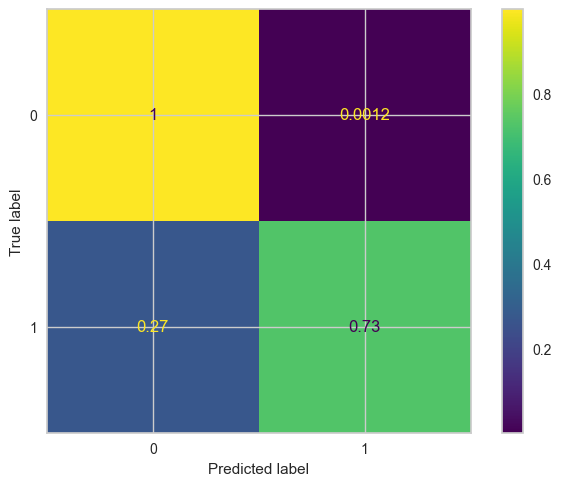

In [275]:
fb_model = FraudModel(train_df)
fb_model.train(epochs=100)
fb_model.evaluate(test_df, confidence=0.90)

[Epoch 0/100] loss: 22.396232
[Epoch 1/100] loss: 16.970010
[Epoch 2/100] loss: 16.217909
[Epoch 3/100] loss: 15.772845
[Epoch 4/100] loss: 15.525131
[Epoch 5/100] loss: 14.966168
[Epoch 6/100] loss: 14.614338
[Epoch 7/100] loss: 14.123138
[Epoch 8/100] loss: 13.859429
[Epoch 9/100] loss: 13.551918
[Epoch 10/100] loss: 13.285500
[Epoch 11/100] loss: 13.065232
[Epoch 12/100] loss: 13.010144
[Epoch 13/100] loss: 12.702908
[Epoch 14/100] loss: 12.473321
[Epoch 15/100] loss: 12.113997
[Epoch 16/100] loss: 11.606338
[Epoch 17/100] loss: 11.065031
[Epoch 18/100] loss: 10.443915
[Epoch 19/100] loss: 10.367779
[Epoch 20/100] loss: 9.667859
[Epoch 21/100] loss: 9.192784
[Epoch 22/100] loss: 8.864924
[Epoch 23/100] loss: 8.748453
[Epoch 24/100] loss: 8.463852
[Epoch 25/100] loss: 8.093347
[Epoch 26/100] loss: 7.869423
[Epoch 27/100] loss: 7.554344
[Epoch 28/100] loss: 7.119982
[Epoch 29/100] loss: 7.029984
[Epoch 30/100] loss: 7.056934
[Epoch 31/100] loss: 6.852385
[Epoch 32/100] loss: 6.825738


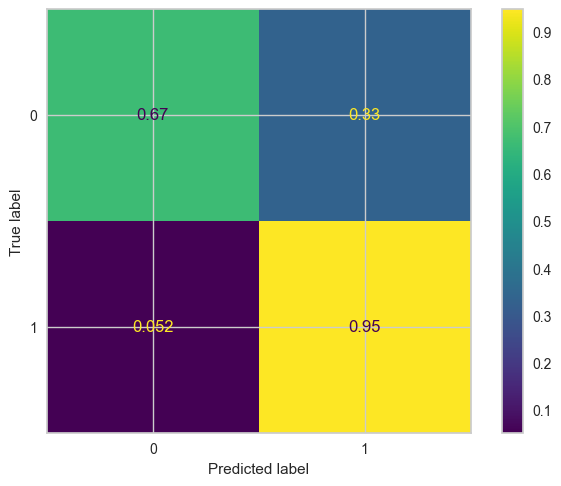

In [276]:
fs_model = FraudModel(gan_train_df)
fs_model.train(epochs=100)
fs_model.evaluate(test_df, confidence=0.90)

[Epoch 0/100] loss: 3.654435
[Epoch 1/100] loss: 2.777880
[Epoch 2/100] loss: 2.646822
[Epoch 3/100] loss: 3.371973
[Epoch 4/100] loss: 3.562521
[Epoch 5/100] loss: 3.236646
[Epoch 6/100] loss: 3.153346
[Epoch 7/100] loss: 2.424212
[Epoch 8/100] loss: 2.055106
[Epoch 9/100] loss: 2.282202
[Epoch 10/100] loss: 2.395538
[Epoch 11/100] loss: 2.257322
[Epoch 12/100] loss: 1.948781
[Epoch 13/100] loss: 1.679897
[Epoch 14/100] loss: 1.429311
[Epoch 15/100] loss: 1.545718
[Epoch 16/100] loss: 1.522534
[Epoch 17/100] loss: 1.713732
[Epoch 18/100] loss: 1.308000
[Epoch 19/100] loss: 1.344139
[Epoch 20/100] loss: 1.086337
[Epoch 21/100] loss: 1.308088
[Epoch 22/100] loss: 1.165495
[Epoch 23/100] loss: 1.309207
[Epoch 24/100] loss: 1.012905
[Epoch 25/100] loss: 0.935719
[Epoch 26/100] loss: 1.068133
[Epoch 27/100] loss: 0.936328
[Epoch 28/100] loss: 0.983465
[Epoch 29/100] loss: 0.770176
[Epoch 30/100] loss: 0.690430
[Epoch 31/100] loss: 0.706815
[Epoch 32/100] loss: 0.648848
[Epoch 33/100] loss:

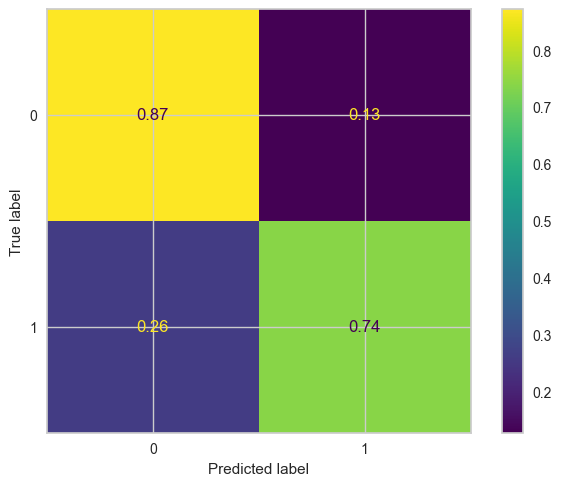

In [277]:
fw_model = FraudModel(wgan_train_df)
fw_model.train(epochs=100)
fw_model.evaluate(test_df, confidence=0.90)